In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/kechoi/multi-fairgen/notebooks'

In [4]:
cd ../src

/atlas/u/kechoi/multi-fairgen/src


In [5]:
from classification.models.mlp import MLPClassifier, MLPClassifierv2
from classification.models.flow_mlp import FlowClassifier
import argparse
import yaml

In [6]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    if isinstance(config, list):
        # from creating config files
        for i in range(len(config)):
            for key, value in config[i].items():
                if isinstance(value, dict):
                    new_value = dict2namespace(value)
                else:
                    new_value = value
                setattr(namespace, key, new_value)
    else:
        # vanilla training
        for key, value in config.items():
            if isinstance(value, dict):
                new_value = dict2namespace(value)
            else:
                new_value = value
            setattr(namespace, key, new_value)
    return namespace

# Load data

In [7]:
import torch
from torch.distributions import Normal

In [8]:
p = Normal(0, 1)
q = Normal(3, 1)

In [9]:
px = p.sample((2000,2))
qx = q.sample((2000,2))

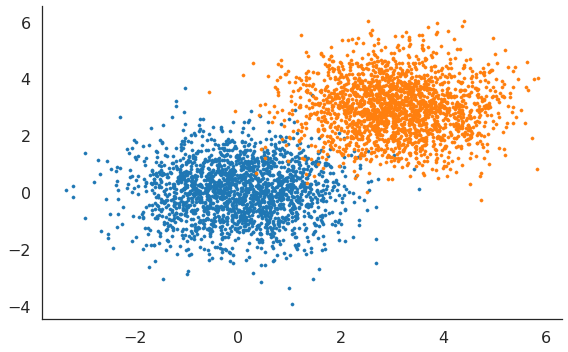

In [10]:
plt.figure(figsize=(8,5))
plt.scatter(px[:,0], px[:,1], label='px', s=10)
plt.scatter(qx[:,0], qx[:,1], label='qx', s=10)

plt.tight_layout()
sns.despine()

In [11]:
true_xs = torch.cat([px, qx])
true_xs.shape

torch.Size([4000, 2])

In [12]:
true_ratios = torch.exp((q.log_prob(true_xs).sum(-1) - p.log_prob(true_xs).sum(-1)))

In [13]:
true_log_r = torch.log(true_ratios)

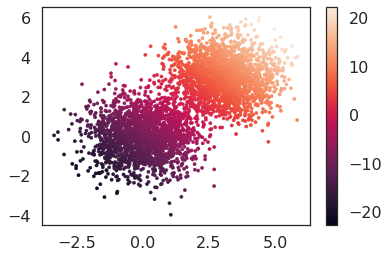

In [14]:
plt.scatter(true_xs[:,0].data.cpu().numpy(), true_xs[:,1].data.cpu().numpy(), s=10, c=true_log_r.data.cpu().numpy())
plt.colorbar()

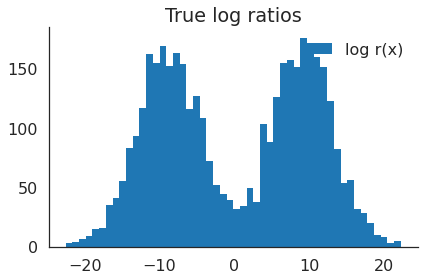

In [15]:
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('True log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

------

# Check encodings

### Check real data

In [28]:
cd multi-fairgen/src

/atlas/u/kechoi/multi-fairgen/src


In [21]:
# load data
data_dir = '../data/'
split = 'test'
dim = 2
rho = 0.95
fpath = os.path.join(data_dir, 'gaussians_mi', '{}_d{}_rho{}.npz'.format(split, dim, rho))

In [22]:
record = np.load(fpath)
p = record['p'][0:5000]
q = record['q'][0:5000]
true_xs = np.vstack([p, q])
true_xs.shape

(10000, 2)

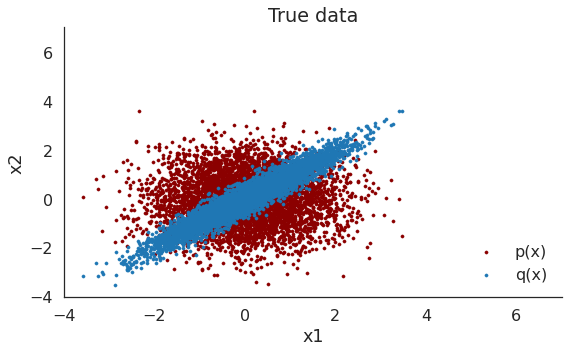

In [23]:
plt.figure(figsize=(8,5))
plt.scatter(p[:,0], p[:,1], s=10, label='p(x)', color='darkred')
plt.scatter(q[:,0], q[:,1], s=10, label='q(x)')
plt.ylim(-4, 7)
plt.xlim(-4, 7)

plt.title('True data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='lower right')
sns.despine()
plt.tight_layout()

# Load flow

In [77]:
cd ../

/atlas/u/kechoi/multi-fairgen/src


In [81]:
device = 'cuda'

In [82]:
# load flow
import os
from flows.models.maf import MAF

model = MAF(5, 
            2, 
            100, 
            1, 
            None, 
            'relu', 
            'sequential', 
            batch_norm=True)
restore_file = 'flows/results/gmm_perc1.0/'
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location='cuda')
model.load_state_dict(state['model_state'])
model = model.to(device)
model.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      

In [85]:
xhat, _ = model.inverse(torch.from_numpy(z).float().cuda())

In [86]:
xhat.size()

torch.Size([10000, 2])

In [87]:
x_hat = xhat.data.cpu().numpy()

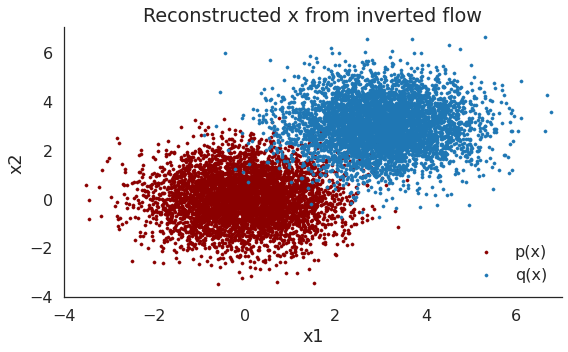

In [90]:
plt.figure(figsize=(8,5))
plt.scatter(x_hat[:,0][:5000], x_hat[:,1][:5000], s=10, label='p(x)', color='darkred')
plt.scatter(x_hat[:,0][5000:], x_hat[:,1][5000:], s=10, label='q(x)')
plt.ylim(-4, 7)
plt.xlim(-4, 7)

plt.title('Reconstructed x from inverted flow')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='lower right')
sns.despine()
plt.tight_layout()

--------

# Discriminative FlowClassifier

In [18]:
device = 'cuda'

In [19]:
with open(os.path.join('configs/classification/mi/disc_flow_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [20]:
flow_mlp = FlowClassifier(new_config)
restore_file = 'classification/results/mi_disc_flow_mlp_perc1.0/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
flow_mlp.load_state_dict(state['state_dict'])
flow_mlp = flow_mlp.to(device)

In [25]:
# get dres
flow_mlp.eval()
z = flow_mlp.flow_encode(torch.from_numpy(true_xs).float().cuda())
z = z.data.cpu().numpy()

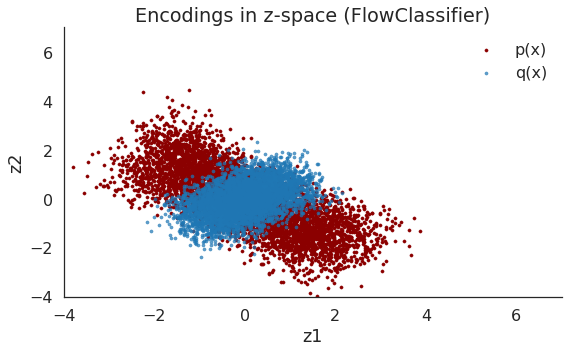

In [26]:
plt.figure(figsize=(8,5))
plt.scatter(z[:,0][:5000], z[:,1][:5000], s=10, label='p(x)', color='darkred')
plt.scatter(z[:,0][5000:], z[:,1][5000:], s=10, alpha=0.7, label='q(x)')
plt.ylim(-4, 7)
plt.xlim(-4, 7)

plt.title('Encodings in z-space (FlowClassifier)')
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()
sns.despine()
plt.tight_layout()

# Jointly trained

In [27]:
with open(os.path.join('configs/classification/mi/joint_flow_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [28]:
flow_mlp = FlowClassifier(new_config)
restore_file = 'classification/results/mi_flow_mlp_perc1.0/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
flow_mlp.load_state_dict(state['state_dict'])
flow_mlp = flow_mlp.to(device)

In [29]:
# get dres
flow_mlp.eval()
z = flow_mlp.flow_encode(torch.from_numpy(true_xs).float().cuda())
z = z.data.cpu().numpy()

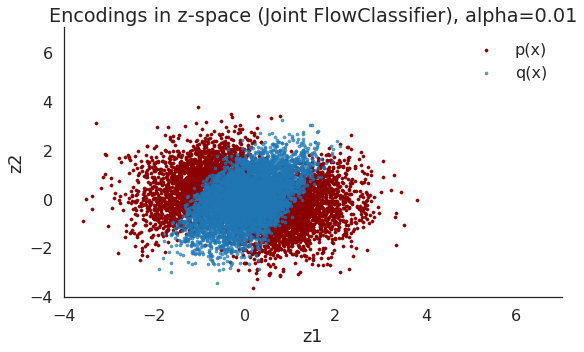

In [30]:
plt.figure(figsize=(8,5))
plt.scatter(z[:,0][:5000], z[:,1][:5000], s=10, label='p(x)', color='darkred')
plt.scatter(z[:,0][5000:], z[:,1][5000:], s=10, alpha=0.7, label='q(x)')
plt.ylim(-4, 7)
plt.xlim(-4, 7)

plt.title('Encodings in z-space (Joint FlowClassifier), alpha=0.01')
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()
sns.despine()
plt.tight_layout()

# X-Space Baseline

actually can't look at encodings here but you can check DREs

In [31]:
with open(os.path.join('configs/classification/mi/mi_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [32]:
mlp = MLPClassifierv2(new_config)
restore_file = 'classification/results/mi_perc1.0/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
mlp.load_state_dict(state['state_dict'])
mlp = mlp.to(device)

In [ ]:
# get dres
mlp.eval()
z = mlp.flow_encode(torch.from_numpy(true_xs).float().cuda())
z = z.data.cpu().numpy()

# Flow